### Import libraries

In [18]:
import pandas as pd
import numpy as np
import pathlib
from typing import Tuple, Any, List, Union

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import (
    StratifiedKFold,
    cross_validate,
    cross_val_predict,
    GridSearchCV,
)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score
from sklearn.utils import shuffle
from joblib import load
import matplotlib.pyplot as plt

import seaborn as sns

### Helper functions

In [19]:
def get_features_data(load_path: pathlib.Path) -> pd.DataFrame:
    """get DP training data from csv at load path

    Args:
        load_path (pathlib.Path): path to training data csv

    Returns:
        pd.DataFrame: training dataframe
    """
    # read dataset into pandas dataframe
    training_data = pd.read_csv(load_path, index_col=0)

    # remove training data with ADCCM class as this class was not used for classification in original paper
    training_data = training_data[
        training_data["Mitocheck_Phenotypic_Class"] != "ADCCM"
    ]

    # replace shape1 and shape3 labels with their correct respective classes
    training_data = training_data.replace("Shape1", "Binuclear")
    training_data = training_data.replace("Shape3", "Polylobed")

    return training_data

def get_testing_data(features_dataframe: pd.DataFrame, data_split_indexes: pd.DataFrame) -> pd.DataFrame:
    """get testing data from features dataframe and the data split indexes

    Args:
        features_dataframe (pd.DataFrame): dataframe with all features data
        data_split_indexes (pd.DataFrame): dataframe with split indexes

    Returns:
        pd.DataFrame: _description_
    """
    testing_indexes = data_split_indexes.loc[data_split_indexes['label'] == "test"]
    testing_indexes = testing_indexes["index"]
    testing_data = features_dataframe.loc[testing_indexes]
    
    return testing_data


def get_holdout_data(features_dataframe: pd.DataFrame, data_split_indexes: pd.DataFrame) -> pd.DataFrame:
    """get holdout data from features dataframe and the data split indexes

    Args:
        features_dataframe (pd.DataFrame): dataframe with all features data
        data_split_indexes (pd.DataFrame): dataframe with split indexes

    Returns:
        pd.DataFrame: _description_
    """
    holdout_indexes = data_split_indexes.loc[data_split_indexes['label'] == "holdout"]
    holdout_indexes = holdout_indexes["index"]
    holdout_data = features_dataframe.loc[holdout_indexes]
    
    return holdout_data


def get_training_data(features_dataframe: pd.DataFrame, data_split_indexes: pd.DataFrame) -> pd.DataFrame:
    """get training data from features dataframe and the data split indexes

    Args:
        features_dataframe (pd.DataFrame): dataframe with all features data
        data_split_indexes (pd.DataFrame): dataframe with split indexes

    Returns:
        pd.DataFrame: _description_
    """
    training_indexes = data_split_indexes.loc[data_split_indexes['label'] == "train"]
    training_indexes = training_indexes["index"]
    training_data = features_dataframe.loc[training_indexes]
    
    return training_data
    

def get_X_y_data(training_data: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """generate X (features) and y (labels) dataframes from training data

    Args:
        training_data (pd.DataFrame): training dataframe

    Returns:
        Tuple[pd.DataFrame, pd.DataFrame]: X, y dataframes
    """

    # all features from DeepProfiler have "efficientnet" in their column name
    morphology_features = [
        col for col in training_data.columns.tolist() if "efficientnet" in col
    ]

    # extract features
    X = training_data.loc[:, morphology_features].values

    # extract phenotypic class label
    y = training_data.loc[:, ["Mitocheck_Phenotypic_Class"]].values
    # make Y data
    y = np.ravel(y)

    # shuffle data because as it comes from MitoCheck same labels tend to be in grou
    X, y = shuffle(X, y, random_state=0)

    return X, y



### Evaluate best model

In [20]:
# results dir for loading/saving
results_dir = pathlib.Path("results/")

log_reg_model_path = pathlib.Path(f"{results_dir}/log_reg_model.joblib")
log_reg_model = load(log_reg_model_path) 

### Evaluate with testing data

In [21]:
# load training data from indexes and features dataframe
data_split_path = pathlib.Path("results/data_split_indexes.tsv")
features_dataframe_path = pathlib.Path("../1.format_data/data/training_data.csv.gz")

features_dataframe = get_features_data(features_dataframe_path)
data_split_indexes = pd.read_csv(data_split_path, sep="\t", index_col=0)

testing_data = get_testing_data(features_dataframe, data_split_indexes)
X_test, y_test = get_X_y_data(testing_data)
testing_data

,Mitocheck_Phenotypic_Class,Mitocheck_Object_ID,Location_Center_X,Location_Center_Y,Metadata_Plate,Metadata_Well,Metadata_Site,Metadata_Plate_Map_Name,Metadata_DNA,Metadata_Gene,...,efficientnet_1270,efficientnet_1271,efficientnet_1272,efficientnet_1273,efficientnet_1274,efficientnet_1275,efficientnet_1276,efficientnet_1277,efficientnet_1278,efficientnet_1279
822,Polylobed,137.0,327.410256,646.923077,LT0023_04,005_51,1,LT0023_04_005_51,LT0023_04/005/51/LT0023_04_005_51.tif,MYST1,...,-0.166159,-0.467381,-0.384447,-0.550383,0.433517,-0.865324,0.016002,-0.109840,-0.701990,-0.094135
2016,Polylobed,64.0,160.329114,367.886076,LT0027_44,292_88,1,LT0027_44_292_88,LT0027_44/292/88/LT0027_44_292_88.tif,CDK4,...,0.085433,-0.434291,-0.449601,0.246126,-0.702891,-0.292118,0.899717,0.184986,-0.125387,0.753049
1983,Hole,11.0,1039.750000,57.180000,LT0027_44,292_80,1,LT0027_44_292_80,LT0027_44/292/80/LT0027_44_292_80.tif,CDK4,...,-0.593846,4.130462,-0.666212,-0.758229,-0.446862,-0.254297,0.853913,0.954494,1.898441,1.589563
3769,Binuclear,152.0,126.024691,860.604938,LT0047_27,140_68,1,LT0047_27_140_68,LT0047_27/140/68/LT0047_27_140_68.tif,DNCH1,...,0.321516,-0.604110,-0.262048,-0.529874,0.281498,-1.447184,0.348561,0.667497,-0.225261,-0.831378
2111,Polylobed,15.0,268.927711,110.927711,LT0067_02,099_77,1,LT0067_02_099_77,LT0067_02/099/77/LT0067_02_099_77.tif,ANLN,...,0.784792,-0.913423,-0.420647,-0.249487,-0.081789,0.347115,0.207262,0.406614,-0.042875,-0.507416
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3577,Binuclear,28.0,982.097826,138.010870,LT0013_42,107_28,1,LT0013_42_107_28,LT0013_42/107/28/LT0013_42_107_28.tif,TUBB2,...,-0.395706,3.128713,0.252267,-0.150522,-0.962759,-1.500189,-1.395892,-0.028810,-0.537501,1.215451
2452,Polylobed,86.0,952.462500,848.800000,LT0109_38,338_80,1,LT0109_38_338_80,LT0109_38/338/80/LT0109_38_338_80.tif,Eg5,...,0.544624,0.555469,-0.039290,1.689157,-0.708886,-1.257283,0.583990,0.009655,0.135534,-0.228725
1166,Polylobed,57.0,125.938272,254.827160,LT0084_46,003_80,1,LT0084_46_003_80,LT0084_46/003/80/LT0084_46_003_80.tif,ENSG00000138180,...,0.533370,-0.866535,-0.332786,-1.045249,0.598749,-1.512270,0.000619,-1.031773,-0.291101,0.480074
1129,Polylobed,74.0,816.764706,301.682353,LT0028_14,129_66,1,LT0028_14_129_66,LT0028_14/129/66/LT0028_14_129_66.tif,CDKL5,...,-1.251656,3.585634,0.710059,-0.007573,0.614177,-0.267979,-1.040327,0.679008,-0.823222,1.401396


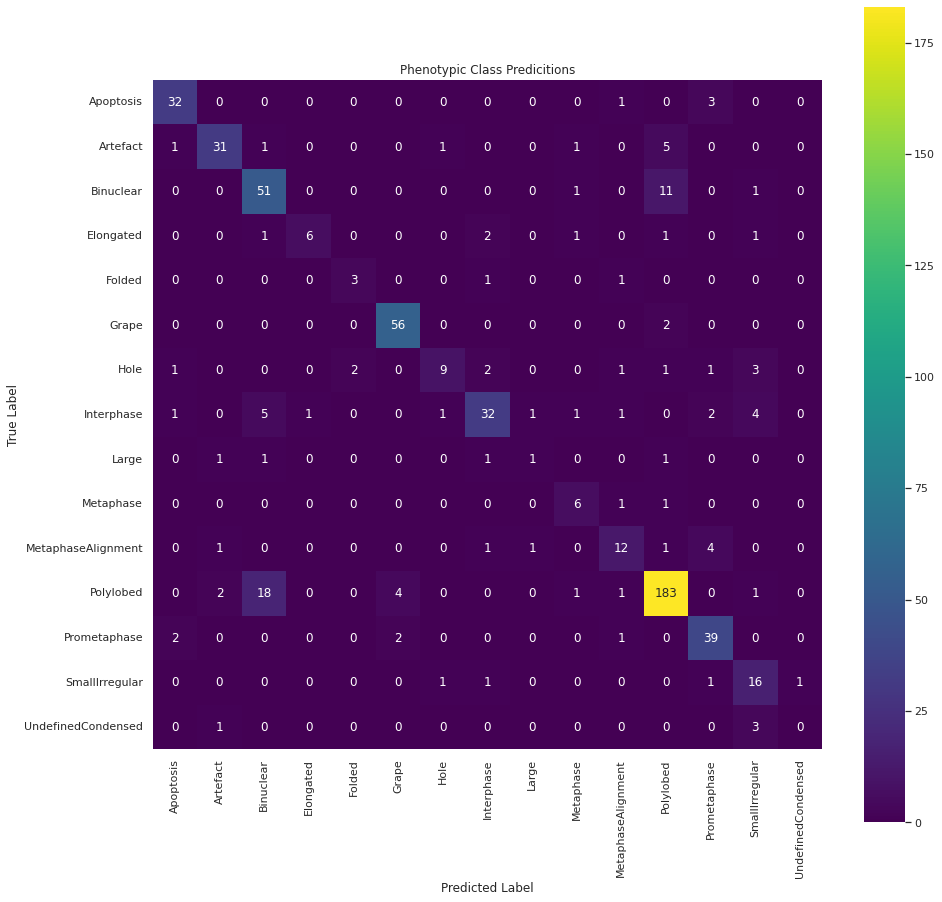

In [22]:
y_test_pred = log_reg_model.predict(X_test)
conf_mat = confusion_matrix(y_test, y_test_pred, labels=log_reg_model.classes_)

conf_mat = pd.DataFrame(conf_mat)
conf_mat.columns = log_reg_model.classes_
conf_mat.index = log_reg_model.classes_

# display confusion matrix
plt.figure(figsize=(15, 15))
ax = sns.heatmap(data=conf_mat, annot=True, fmt=".0f", cmap="viridis", square=True)
ax = plt.xlabel("Predicted Label")
ax = plt.ylabel("True Label")
ax = plt.title("Phenotypic Class Predicitions")

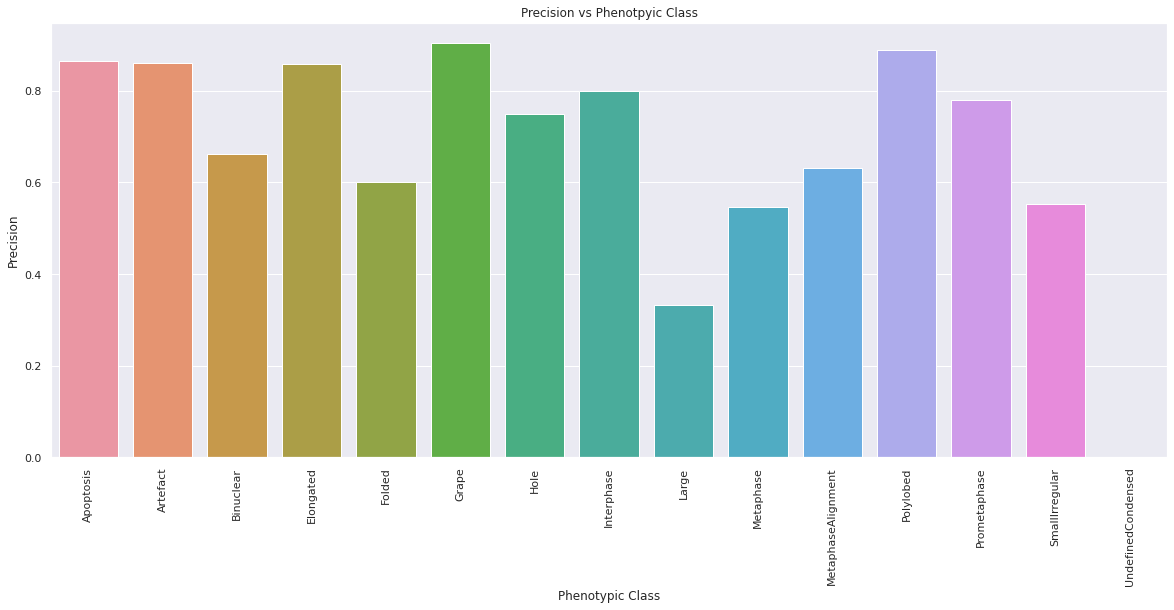

In [23]:
# display precision vs phenotypic class bar chart
precisions = precision_score(y_test, y_test_pred, average=None)
precisions = pd.DataFrame(precisions).T
precisions.columns = np.unique(y_test_pred) #cant use log_reg_model.classes_ because classes may be missing due to lack of data

sns.set(rc={"figure.figsize": (20, 8)})
plt.xlabel("Phenotypic Class")
plt.ylabel("Precision")
plt.title("Precision vs Phenotpyic Class")
plt.xticks(rotation=90)
ax = sns.barplot(data=precisions)

### Evaluate with holdout data

In [24]:
holdout_data = get_holdout_data(features_dataframe, data_split_indexes)
X_holdout, y_holdout = get_X_y_data(holdout_data)
holdout_data

,Mitocheck_Phenotypic_Class,Mitocheck_Object_ID,Location_Center_X,Location_Center_Y,Metadata_Plate,Metadata_Well,Metadata_Site,Metadata_Plate_Map_Name,Metadata_DNA,Metadata_Gene,...,efficientnet_1270,efficientnet_1271,efficientnet_1272,efficientnet_1273,efficientnet_1274,efficientnet_1275,efficientnet_1276,efficientnet_1277,efficientnet_1278,efficientnet_1279
4186,MetaphaseAlignment,105.0,342.973684,210.342105,LT0090_33,383_60,1,LT0090_33_383_60,LT0090_33/383/60/LT0090_33_383_60.tif,failed_QC,...,0.994635,1.908588,-0.827825,-0.245325,-0.415855,-0.915273,-0.297144,-0.575251,-0.073605,2.009363
4187,MetaphaseAlignment,105.0,343.555556,227.986111,LT0090_33,383_60,1,LT0090_33_383_60,LT0090_33/383/60/LT0090_33_383_60.tif,failed_QC,...,0.851463,1.134895,-0.031991,0.637901,0.130440,-0.235504,0.538804,-0.064468,-0.072319,1.747850
4188,MetaphaseAlignment,229.0,1263.530864,586.086420,LT0090_33,383_60,1,LT0090_33_383_60,LT0090_33/383/60/LT0090_33_383_60.tif,failed_QC,...,0.412276,-0.264889,0.295659,-0.478046,-0.047345,-0.542486,1.030637,-0.033724,-0.499721,1.075325
4189,MetaphaseAlignment,230.0,601.092308,593.292308,LT0090_33,383_60,1,LT0090_33_383_60,LT0090_33/383/60/LT0090_33_383_60.tif,failed_QC,...,0.329826,-0.415136,-0.335016,-0.819550,-0.081502,0.694631,0.798954,-0.425629,0.335101,0.692230
107,Metaphase,26.0,726.985915,55.591549,LT0043_48,166_71,1,LT0043_48_166_71,LT0043_48/166/71/LT0043_48_166_71.tif,OGG1,...,0.547156,-0.564286,-0.498775,-0.459153,-0.267186,-0.903834,0.137039,-0.250470,0.186182,0.894334
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2514,Interphase,85.0,1002.897436,923.205128,LT0109_38,338_27,1,LT0109_38_338_27,LT0109_38/338/27/LT0109_38_338_27.tif,Eg5,...,0.727443,3.866696,0.311543,-0.762706,-0.431894,-1.343273,0.725883,0.011744,0.529313,0.872427
2515,Interphase,86.0,74.784810,929.886076,LT0109_38,338_27,1,LT0109_38_338_27,LT0109_38/338/27/LT0109_38_338_27.tif,Eg5,...,-0.325549,-0.400540,-0.182039,1.506601,-0.365787,-0.678321,0.923729,0.816452,0.313573,0.410623
2516,Prometaphase,87.0,210.000000,941.042857,LT0109_38,338_27,1,LT0109_38_338_27,LT0109_38/338/27/LT0109_38_338_27.tif,Eg5,...,-0.017610,-0.283508,-0.622474,0.205071,-0.698125,0.083607,-0.249165,0.367940,0.198255,-1.703105
2517,Interphase,88.0,22.063158,972.578947,LT0109_38,338_27,1,LT0109_38_338_27,LT0109_38/338/27/LT0109_38_338_27.tif,Eg5,...,0.130452,-0.023701,-0.483479,-0.247751,-0.532591,-0.396286,0.387391,0.680529,0.835031,0.245575


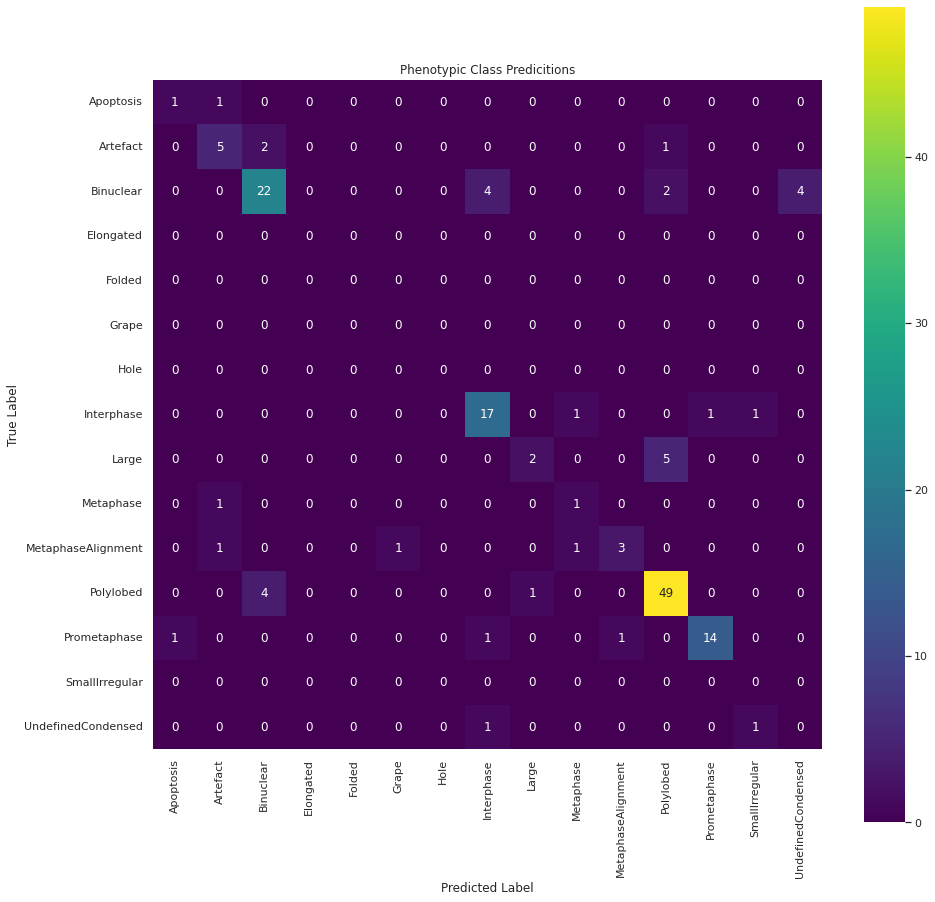

In [25]:
y_holdout_pred = log_reg_model.predict(X_holdout)
conf_mat = confusion_matrix(y_holdout, y_holdout_pred, labels=log_reg_model.classes_)

conf_mat = pd.DataFrame(conf_mat)
conf_mat.columns = log_reg_model.classes_
conf_mat.index = log_reg_model.classes_

# display confusion matrix
plt.figure(figsize=(15, 15))
ax = sns.heatmap(data=conf_mat, annot=True, fmt=".0f", cmap="viridis", square=True)
ax = plt.xlabel("Predicted Label")
ax = plt.ylabel("True Label")
ax = plt.title("Phenotypic Class Predicitions")

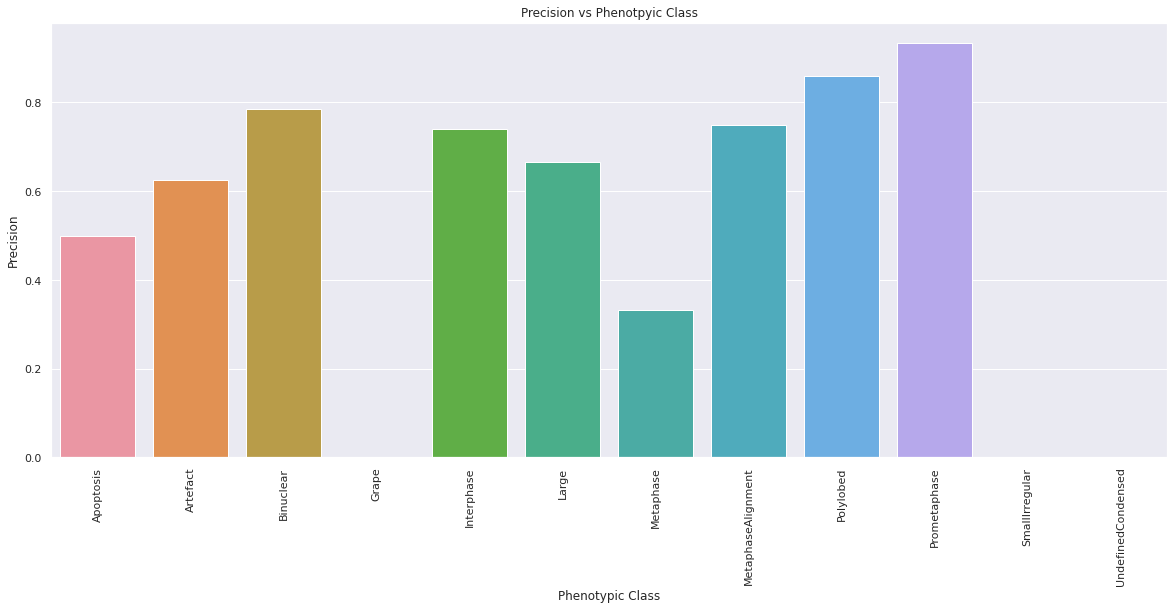

In [26]:
# display precision vs phenotypic class bar chart
precisions = precision_score(y_holdout, y_holdout_pred, average=None)
precisions = pd.DataFrame(precisions).T
precisions.columns = np.unique(y_holdout_pred) #cant use log_reg_model.classes_ because classes may be missing due to lack of data

sns.set(rc={"figure.figsize": (20, 8)})
plt.xlabel("Phenotypic Class")
plt.ylabel("Precision")
plt.title("Precision vs Phenotpyic Class")
plt.xticks(rotation=90)
ax = sns.barplot(data=precisions)

### Evaluate with training data

In [27]:
training_data = get_training_data(features_dataframe, data_split_indexes)
X_training, y_training = get_X_y_data(training_data)
training_data

,Mitocheck_Phenotypic_Class,Mitocheck_Object_ID,Location_Center_X,Location_Center_Y,Metadata_Plate,Metadata_Well,Metadata_Site,Metadata_Plate_Map_Name,Metadata_DNA,Metadata_Gene,...,efficientnet_1270,efficientnet_1271,efficientnet_1272,efficientnet_1273,efficientnet_1274,efficientnet_1275,efficientnet_1276,efficientnet_1277,efficientnet_1278,efficientnet_1279
4,Polylobed,10.0,1212.640449,21.314607,LT0043_48,166_55,1,LT0043_48_166_55,LT0043_48/166/55/LT0043_48_166_55.tif,OGG1,...,1.764085,-0.364659,-0.623983,0.087524,-0.678471,-1.047430,0.119700,0.254014,0.080685,-0.808582
5,MetaphaseAlignment,42.0,69.902174,104.782609,LT0043_48,166_55,1,LT0043_48_166_55,LT0043_48/166/55/LT0043_48_166_55.tif,OGG1,...,-0.030402,-0.306105,0.471312,1.111647,-0.395580,0.265579,0.337486,-0.728758,0.519263,1.143726
7,Interphase,85.0,1155.936170,191.180851,LT0043_48,166_55,1,LT0043_48_166_55,LT0043_48/166/55/LT0043_48_166_55.tif,OGG1,...,-1.264048,-0.678396,0.076916,3.142620,0.202174,0.331271,0.567700,0.072269,-1.715632,1.303155
9,Artefact,108.0,795.484536,242.752577,LT0043_48,166_55,1,LT0043_48_166_55,LT0043_48/166/55/LT0043_48_166_55.tif,OGG1,...,-1.406520,0.368818,0.568022,1.618059,-0.320691,0.527715,0.130431,-0.293846,-0.755968,0.025133
10,Artefact,100.0,744.214286,236.428571,LT0043_48,166_55,1,LT0043_48_166_55,LT0043_48/166/55/LT0043_48_166_55.tif,OGG1,...,-0.313731,0.189396,0.359831,0.693035,-0.039102,0.101826,0.783466,-0.191989,-0.278789,1.324181
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4303,SmallIrregular,37.0,828.268657,338.328358,LT0106_02,287_33,1,LT0106_02_287_33,LT0106_02/287/33/LT0106_02_287_33.tif,ENSG00000186143,...,-0.010054,2.490791,0.112932,-0.448705,-0.573112,-1.219449,0.756078,-0.434373,-0.617329,2.989479
4304,SmallIrregular,45.0,62.742424,384.424242,LT0106_02,287_33,1,LT0106_02_287_33,LT0106_02/287/33/LT0106_02_287_33.tif,ENSG00000186143,...,0.828838,2.328690,2.365700,-1.219878,-0.377726,0.285707,0.072360,-0.101487,0.592109,-0.326425
4305,SmallIrregular,49.0,799.772727,407.651515,LT0106_02,287_33,1,LT0106_02_287_33,LT0106_02/287/33/LT0106_02_287_33.tif,ENSG00000186143,...,0.342158,1.118108,2.618269,-1.146326,-0.574519,0.284514,0.491826,-0.489022,0.969788,-0.492233
4306,SmallIrregular,52.0,105.014085,429.056338,LT0106_02,287_33,1,LT0106_02_287_33,LT0106_02/287/33/LT0106_02_287_33.tif,ENSG00000186143,...,-0.890952,0.301522,0.345463,0.594489,0.737245,3.037339,-0.636915,0.061156,1.849867,-0.896322


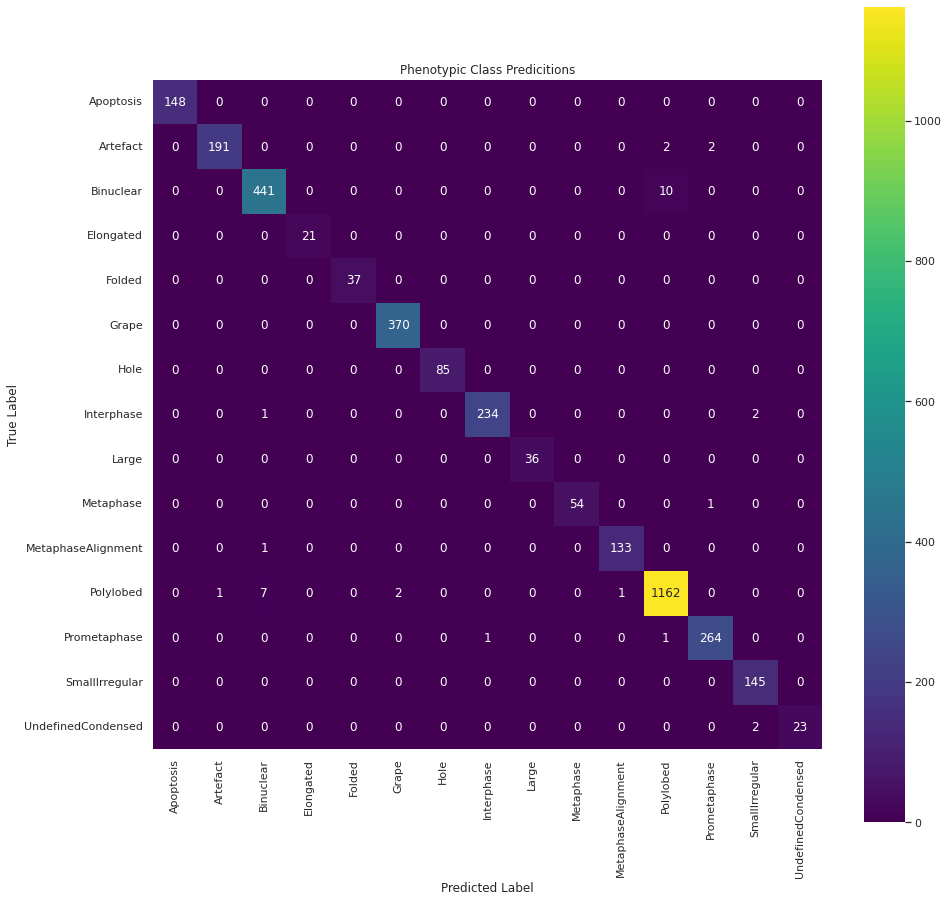

In [28]:
y_training_pred = log_reg_model.predict(X_training)
conf_mat = confusion_matrix(y_training, y_training_pred, labels=log_reg_model.classes_)

conf_mat = pd.DataFrame(conf_mat)
conf_mat.columns = log_reg_model.classes_
conf_mat.index = log_reg_model.classes_

# display confusion matrix
plt.figure(figsize=(15, 15))
ax = sns.heatmap(data=conf_mat, annot=True, fmt=".0f", cmap="viridis", square=True)
ax = plt.xlabel("Predicted Label")
ax = plt.ylabel("True Label")
ax = plt.title("Phenotypic Class Predicitions")

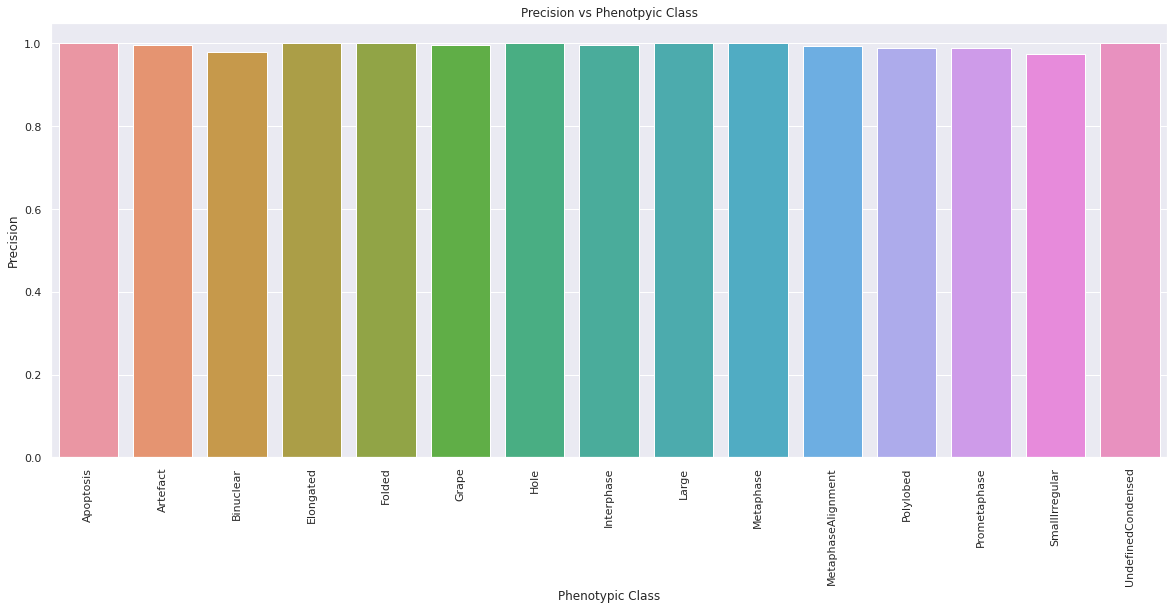

In [29]:
# display precision vs phenotypic class bar chart
precisions = precision_score(y_training, y_training_pred, average=None)
precisions = pd.DataFrame(precisions).T
precisions.columns = np.unique(y_training_pred) #cant use log_reg_model.classes_ because classes may be missing due to lack of data

sns.set(rc={"figure.figsize": (20, 8)})
plt.xlabel("Phenotypic Class")
plt.ylabel("Precision")
plt.title("Precision vs Phenotpyic Class")
plt.xticks(rotation=90)
ax = sns.barplot(data=precisions)

### Save trained model predicitions

In [30]:
predictions = []
predictions.append(y_test)
predictions.append(y_test_pred)

predictions.append(y_holdout)
predictions.append(y_holdout_pred)

predictions.append(y_training)
predictions.append(y_training_pred)

predictions = pd.DataFrame(predictions)
predictions.index = ["y_test", "y_test_pred", "y_holdout", "y_holdout_pred", "y_training", "y_training_pred"]
predictions.to_csv(f"{results_dir}/model_predictions.tsv", sep="\t")

### Evaluate shuffled baseline model

In [31]:
log_reg_model_path = pathlib.Path(f"{results_dir}/shuffled_baseline_log_reg_model.joblib")
log_reg_model = load(log_reg_model_path) 

### Evaluate with testing data

In [32]:
# load training data from indexes and features dataframe
data_split_path = pathlib.Path("results/data_split_indexes.tsv")
features_dataframe_path = pathlib.Path("../1.format_data/data/training_data.csv.gz")

features_dataframe = get_features_data(features_dataframe_path)
data_split_indexes = pd.read_csv(data_split_path, sep="\t", index_col=0)

testing_data = get_testing_data(features_dataframe, data_split_indexes)
X_test, y_test = get_X_y_data(testing_data)
testing_data

,Mitocheck_Phenotypic_Class,Mitocheck_Object_ID,Location_Center_X,Location_Center_Y,Metadata_Plate,Metadata_Well,Metadata_Site,Metadata_Plate_Map_Name,Metadata_DNA,Metadata_Gene,...,efficientnet_1270,efficientnet_1271,efficientnet_1272,efficientnet_1273,efficientnet_1274,efficientnet_1275,efficientnet_1276,efficientnet_1277,efficientnet_1278,efficientnet_1279
822,Polylobed,137.0,327.410256,646.923077,LT0023_04,005_51,1,LT0023_04_005_51,LT0023_04/005/51/LT0023_04_005_51.tif,MYST1,...,-0.166159,-0.467381,-0.384447,-0.550383,0.433517,-0.865324,0.016002,-0.109840,-0.701990,-0.094135
2016,Polylobed,64.0,160.329114,367.886076,LT0027_44,292_88,1,LT0027_44_292_88,LT0027_44/292/88/LT0027_44_292_88.tif,CDK4,...,0.085433,-0.434291,-0.449601,0.246126,-0.702891,-0.292118,0.899717,0.184986,-0.125387,0.753049
1983,Hole,11.0,1039.750000,57.180000,LT0027_44,292_80,1,LT0027_44_292_80,LT0027_44/292/80/LT0027_44_292_80.tif,CDK4,...,-0.593846,4.130462,-0.666212,-0.758229,-0.446862,-0.254297,0.853913,0.954494,1.898441,1.589563
3769,Binuclear,152.0,126.024691,860.604938,LT0047_27,140_68,1,LT0047_27_140_68,LT0047_27/140/68/LT0047_27_140_68.tif,DNCH1,...,0.321516,-0.604110,-0.262048,-0.529874,0.281498,-1.447184,0.348561,0.667497,-0.225261,-0.831378
2111,Polylobed,15.0,268.927711,110.927711,LT0067_02,099_77,1,LT0067_02_099_77,LT0067_02/099/77/LT0067_02_099_77.tif,ANLN,...,0.784792,-0.913423,-0.420647,-0.249487,-0.081789,0.347115,0.207262,0.406614,-0.042875,-0.507416
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3577,Binuclear,28.0,982.097826,138.010870,LT0013_42,107_28,1,LT0013_42_107_28,LT0013_42/107/28/LT0013_42_107_28.tif,TUBB2,...,-0.395706,3.128713,0.252267,-0.150522,-0.962759,-1.500189,-1.395892,-0.028810,-0.537501,1.215451
2452,Polylobed,86.0,952.462500,848.800000,LT0109_38,338_80,1,LT0109_38_338_80,LT0109_38/338/80/LT0109_38_338_80.tif,Eg5,...,0.544624,0.555469,-0.039290,1.689157,-0.708886,-1.257283,0.583990,0.009655,0.135534,-0.228725
1166,Polylobed,57.0,125.938272,254.827160,LT0084_46,003_80,1,LT0084_46_003_80,LT0084_46/003/80/LT0084_46_003_80.tif,ENSG00000138180,...,0.533370,-0.866535,-0.332786,-1.045249,0.598749,-1.512270,0.000619,-1.031773,-0.291101,0.480074
1129,Polylobed,74.0,816.764706,301.682353,LT0028_14,129_66,1,LT0028_14_129_66,LT0028_14/129/66/LT0028_14_129_66.tif,CDKL5,...,-1.251656,3.585634,0.710059,-0.007573,0.614177,-0.267979,-1.040327,0.679008,-0.823222,1.401396


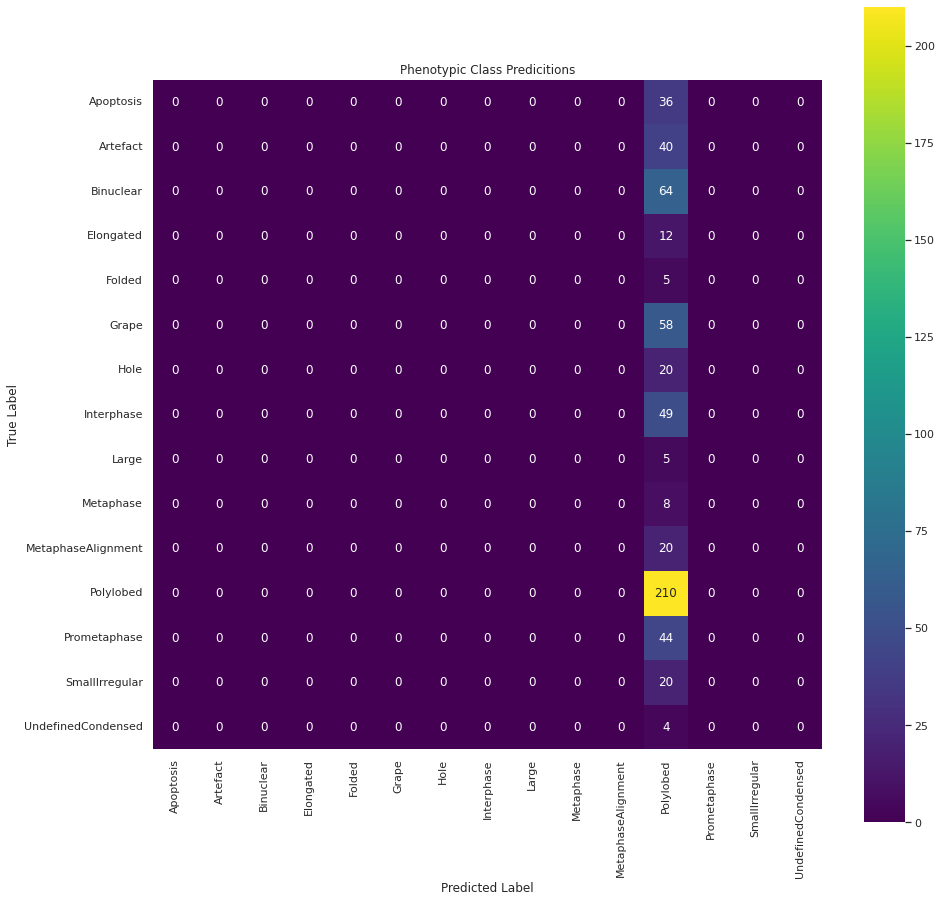

In [33]:
y_test_pred = log_reg_model.predict(X_test)
conf_mat = confusion_matrix(y_test, y_test_pred, labels=log_reg_model.classes_)

conf_mat = pd.DataFrame(conf_mat)
conf_mat.columns = log_reg_model.classes_
conf_mat.index = log_reg_model.classes_

# display confusion matrix
plt.figure(figsize=(15, 15))
ax = sns.heatmap(data=conf_mat, annot=True, fmt=".0f", cmap="viridis", square=True)
ax = plt.xlabel("Predicted Label")
ax = plt.ylabel("True Label")
ax = plt.title("Phenotypic Class Predicitions")

In [34]:
# display precision vs phenotypic class bar chart
precisions = precision_score(y_test, y_test_pred, average=None)
precisions = pd.DataFrame(precisions).T
precisions.columns = np.unique(y_test_pred) #cant use log_reg_model.classes_ because classes may be missing due to lack of data

sns.set(rc={"figure.figsize": (20, 8)})
plt.xlabel("Phenotypic Class")
plt.ylabel("Precision")
plt.title("Precision vs Phenotpyic Class")
plt.xticks(rotation=90)
ax = sns.barplot(data=precisions)

/home/roshankern/anaconda3/envs/2.ML_phenotypic_classification/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


ValueError: Length mismatch: Expected axis has 15 elements, new values have 1 elements

In [37]:
np.unique(y_test)

array(['Apoptosis', 'Artefact', 'Binuclear', 'Elongated', 'Folded',
       'Grape', 'Hole', 'Interphase', 'Large', 'Metaphase',
       'MetaphaseAlignment', 'Polylobed', 'Prometaphase',
       'SmallIrregular', 'UndefinedCondensed'], dtype=object)

### Evaluate with holdout data

In [ ]:
holdout_data = get_holdout_data(features_dataframe, data_split_indexes)
X_holdout, y_holdout = get_X_y_data(holdout_data)
holdout_data

In [ ]:
y_holdout_pred = log_reg_model.predict(X_holdout)
conf_mat = confusion_matrix(y_holdout, y_holdout_pred, labels=log_reg_model.classes_)

conf_mat = pd.DataFrame(conf_mat)
conf_mat.columns = log_reg_model.classes_
conf_mat.index = log_reg_model.classes_

# display confusion matrix
plt.figure(figsize=(15, 15))
ax = sns.heatmap(data=conf_mat, annot=True, fmt=".0f", cmap="viridis", square=True)
ax = plt.xlabel("Predicted Label")
ax = plt.ylabel("True Label")
ax = plt.title("Phenotypic Class Predicitions")

In [ ]:
# display precision vs phenotypic class bar chart
precisions = precision_score(y_holdout, y_holdout_pred, average=None)
precisions = pd.DataFrame(precisions).T
precisions.columns = np.unique(y_holdout_pred) #cant use log_reg_model.classes_ because classes may be missing due to lack of data

sns.set(rc={"figure.figsize": (20, 8)})
plt.xlabel("Phenotypic Class")
plt.ylabel("Precision")
plt.title("Precision vs Phenotpyic Class")
plt.xticks(rotation=90)
ax = sns.barplot(data=precisions)

### Evaluate with training data

In [ ]:
training_data = get_training_data(features_dataframe, data_split_indexes)
X_training, y_training = get_X_y_data(training_data)
training_data

In [ ]:
y_training_pred = log_reg_model.predict(X_training)
conf_mat = confusion_matrix(y_training, y_training_pred, labels=log_reg_model.classes_)

conf_mat = pd.DataFrame(conf_mat)
conf_mat.columns = log_reg_model.classes_
conf_mat.index = log_reg_model.classes_

# display confusion matrix
plt.figure(figsize=(15, 15))
ax = sns.heatmap(data=conf_mat, annot=True, fmt=".0f", cmap="viridis", square=True)
ax = plt.xlabel("Predicted Label")
ax = plt.ylabel("True Label")
ax = plt.title("Phenotypic Class Predicitions")

In [ ]:
# display precision vs phenotypic class bar chart
precisions = precision_score(y_training, y_training_pred, average=None)
precisions = pd.DataFrame(precisions).T
precisions.columns = np.unique(y_training_pred) #cant use log_reg_model.classes_ because classes may be missing due to lack of data

sns.set(rc={"figure.figsize": (20, 8)})
plt.xlabel("Phenotypic Class")
plt.ylabel("Precision")
plt.title("Precision vs Phenotpyic Class")
plt.xticks(rotation=90)
ax = sns.barplot(data=precisions)

### Save trained model predicitions

In [ ]:
predictions = []
predictions.append(y_test)
predictions.append(y_test_pred)

predictions.append(y_holdout)
predictions.append(y_holdout_pred)

predictions.append(y_training)
predictions.append(y_training_pred)

predictions = pd.DataFrame(predictions)
predictions.index = ["y_test", "y_test_pred", "y_holdout", "y_holdout_pred", "y_training", "y_training_pred"]
predictions.to_csv(f"{results_dir}/shuffled_baseline_model_predictions.tsv", sep="\t")